In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install konlpy

In [3]:
!cp '/content/drive/MyDrive/preprocess.py' .

In [4]:
!cp -r '/content/drive/MyDrive/머신러닝, 딥러닝 공부/data_in' .

In [5]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

In [6]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val' + string])
    plt.xlabels('Epochs')
    plt.ylabels(string)
    plt.legend([string, 'val_'+ string])
    plt.show()

In [7]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outpus.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIG = 'data_configs.json'

In [8]:
SEED_NUM = 42
tf.random.set_seed(SEED_NUM)

In [9]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb')) # index_inputs = (11823, 25)
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS, 'rb')) # index_output(11823, 25) MAX_SEQUENCE = 25 preprocess.py를 통해 한번 처리되어 나옴
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS, 'rb'))
prepro_config = json.load(open(DATA_IN_PATH + DATA_CONFIG, 'r'))

In [31]:
index_inputs

array([[10865, 11360,     0, ...,     0,     0,     0],
       [ 4107,   801,  7249, ...,     0,     0,     0],
       [ 7392,  9331,  5903, ...,     0,     0,     0],
       ...,
       [ 9047,  7344, 11726, ...,     0,     0,     0],
       [ 9987, 11965, 10556, ...,     0,     0,     0],
       [ 8960,  4636,  6122, ...,     0,     0,     0]])

In [32]:
index_outputs

array([[    1, 10332,  2506, ...,     0,     0,     0],
       [    1,  7885, 10487, ...,     0,     0,     0],
       [    1,  3039,  2738, ...,     0,     0,     0],
       ...,
       [    1, 12406,     0, ...,     0,     0,     0],
       [    1,  5951,  2760, ...,     0,     0,     0],
       [    1,  8138,  3843, ...,     0,     0,     0]])

In [10]:
index_inputs.shape

(11823, 25)

In [11]:
len(index_inputs), len(index_outputs), len(index_targets)

(11823, 11823, 11823)

In [12]:
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 24
MAX_SEQUENCE = 25 #  preprocess.py에서 처리될때 25로 설정
EPOCH = 30
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1

word2idx = prepro_config['word2idx']
idx2word = prepro_config['idx2word']
sos_idx = prepro_config['sos_symbol']
eos_idx = prepro_config['eos_symbol']
vocab_size = prepro_config['vocab_size'] # vocab_size = 12657




In [13]:
print(vocab_size)

12657


## **Encoder**

In [33]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size): # Encoder(12657, 256, 1024, 24)
        super(Encoder, self).__init__()
        self.batch_size = batch_size # Encoder내부에서 안쓰임
        self.enc_units = enc_units # 1024
        self.embedding_dim = embedding_dim # 256
        self.vocab_size = vocab_size # 12657

        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim) # Embedding(12657, 256)
        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform') # self.enc_units = 1024

    def call(self, x, hidden): # 들어오는 x = (11823, 25), hidden = (11823, 1024)
        # enc_output, enc_hidden = self.encoder(input, enc_hidden) # self.encoder((11823, 25), (11823, 1024))

        x = self.embedding(x) # embedding되어 나온 x = (11823, 25, 256)
        # x = (input(=sample)_size, MAX_SEQUENCE, Embedding_dim)
        output, state = self.gru(x, initial_state=hidden) # gru로 통해 나오는 output = (11823, 25, 1024) # 1024는 GRU의 self.enc_unit으로 결정됨

        return output, state # output = (11823, 25, 1024), state = (11823, 1024)

    def initial_hidden_state(self, input):
        return tf.zeros((tf.shape(input)[0], self.enc_units)) # (11823, 1024)의 matrix를 만듦


## **Attention**

In [34]:
image1 = tf.zeros([11823, 25, 1024])
image2 = tf.zeros([11823, 1, 1024])
a = image1 + image2
a.shape

TensorShape([11823, 25, 1024])

In [35]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units): # units = 1024 (dec_units으로 받아옴)
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) # W1 = Dense(1024)
        self.W2 = tf.keras.layers.Dense(units) # W2 = Dense(1024)
        self.V = tf.keras.layers.Dense(1)
    
    def call(self, query, values):   # query : decorder의 hidden_state, values : encoder의 output
        # self.attention(hidden, enc_output) = ((11823, 1024), (11823, 25, 1024))
        # query = (11823, 1024) = dec_hidden
        # values = (11823, 25, 1024) = enc_output

        hidden_with_time_axis = tf.expand_dims(query, 1) # hidden_with_time_axis = (11823, 1, 1024) <== (11823, 1024)

        score = self.V(tf.nn.tanh( # score를 구하는 방법은 매우 다양함 => score : 얼마나 유사한지
            self.W1(values) + self.W2(hidden_with_time_axis) # 차원을 맞추기 위한 expand_dims => broadcasting이 가능해짐
            # W1(11823, 25, 1024) + W2(11823, 1, 1024) => (11823, 25, 1024)
        )) # score = (11823, 25, 1)

        attention_weights = tf.nn.softmax(score, axis=1) # softmax를 지나고 25개의 숫자를 다 더하면 1

        context_vector = attention_weights * values

        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


## **Decoder**

In [36]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size): # dec_units : RNN을 통과하고 나온 output의 dimension
                                                                                                                        # Decoder(12657, 256, 1024, 24)
        super(Decoder, self).__init__() # self의 객체를 Decoder에 넘겨줌

        self.batch_size = batch_size # Decoder내부 함수에서는 안쓰임(원본책을 봐야할듯)
        self.dec_units = dec_units # output의 dimension, 1024
        self.embedding_dim = embedding_dim # 256
        self.vocab_size = vocab_size # 12657

        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim) # Embedding(12657, 256)
        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform') # GRU(1024)
        # fully connected layer 설정
        self.fc = tf.keras.layers.Dense(self.vocab_size) # 전체 vocabulary중에 하나를 골라야하므로 dimension을 self.vocab_size로 설정 # 12657
        """
        Decoder에서 Bahdanau Attention사용
        """
        self.attention = BahdanauAttention(self.dec_units) # BahdanauAttention(1024)

    def call(self, x, hidden, enc_output):        # self.decoder(dec_input, dec_hidden, enc_output)
                                                                        # self.decoder = ((25, 1), (11823, 1024), (11823, 25, 1024))
                                                                        # x = (25, 1), hidden = (11823, 1024), enc_output = (11823, 25, 1024)

                                                                        # hidden = dec_hidden = enc_hidden
        context_vector, attention_weight = self.attention(hidden, enc_output) # self.attention = ((11823, 1024), (11823, 25, 1024))

        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis= -1) # axis= -1

        output, state = self.gru(x) # gru로 들어가는 x는 위 과정을 통해 열이 더해짐
        output = tf.reshape(output, (-1, output.shape[2])) # 차원을 맞추는 과정

        x = self.fc(output)

        return x, state, attention_weight


## **Optimizer, Loss, Accuracy**

In [37]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

In [38]:
def loss(real, pred): # real 과 pred는 array나 tensor형태로 들어옴
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # read와 0(pad token)이 같은지 확인( 0 : PAD) ; pad가 있으면 True지만 logical_not으로 인해 False로 나옴
    loss_ = loss_fn(real, pred) #loss_fn의 반환값으로 array나 tensor로 반환
    mask = tf.cast(mask, dtype=loss_.dtype) # tf.cast : Casts a tensor to a new type. 새로운 타입으로 변경
    loss_ *= mask # 행렬곱연산이라 pad와 행렬곱이 되는 부분은 0이 됨

    return tf.reduce_mean(loss_)

def accuracy(real, pred): 
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # logical_not 단순히 결과를 반대로 바꿈 (True -> False, False -> True)
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis= -1)
    pred *= mask
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

## **Model**

In [39]:
class Seq2Seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_size, end_token_id = EOS_INDEX):
        super(Seq2Seq, self).__init__()
        self.end_token_id = end_token_id

        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_size) # Encoder(12657, 256, 1024, 24)
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_size) # Decoder(12657, 256, 1024, 24)


    def call(self, x):
        input, target = x 
        # model.fit에서 주어지는 입력 값을 각각 받음 ; [index_inputs, index_outputs]
        # input = index_inputs (11823, 25)
        # target = index_outputs (11823, 25)

        enc_hidden = self.encoder.initial_hidden_state(input) # self.encoder.initial_hidden_state((11823, 25))
        # enc_hidden = (11823, 1024), 일단 0으로만 채워진 matrix가 나옴
        """
                def initial_hidden_state(self, input):
                    return tf.zeros((tf.shape(input)[0], self.enc_units)) # (11823, 1024)의 matrix를 만듦
        """
        enc_output, enc_hidden = self.encoder(input, enc_hidden) # self.encoder((11823, 25), (11823, 1024))
        """
        self.encoder을 지나면 return값으로 output, state 나옴
        output = (11823, 25, 1024), state = (11823, 1024) 그것을 enc_output, enc_hidden으로 받음
        """
        # enc_output = (11823, 25, 1024)
        # enc_hidden = (11823, 1024)  <=  0으로만 채워진 enc_hidden은 self.encoder를 통해 값이 채워짐

        dec_hidden = enc_hidden # 구조의 흐름상 encoder의 hidden_state값을 decoder의 hidden_state으로 넘겨주는 부분

        predict_tokens =  []

        # target = index_outputs (11823, 25)
        for t in range(target.shape[1]): # target.shape[1] = 25 = MAX_SEQUENCE
            dec_input = tf.dtypes.cast(tf.expand_dims(target[:, t], 1), tf.float32) # target[:, t] 입력을 가져옴 (25, 1)
            # dec_input을 거치면 수직모양의 열이 1개인 vector가 생성 => 행렬계산을 하기 위함 dec_input = (25, 1) # 단어 하나가 세로로

            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output) #self.decoder = ((25, 1), (11823, 1024), (11823, 25, 1024) )

            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32)) # predictions의 dtype을 float32로 변경후 predict_token에 넣음

        return tf.stack(predict_tokens, axis=1)

    def inference(self, x):
        input = x

        enc_hidden = self.encoder.initial_hidden_state(input)
        enc_output, enc_hidden = self.encoder(input, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([word2idx[sos_index]], 1)

        predict_tokens = []
        for t in range(MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0])

            if predict_token == self.end_token_id:
                break
            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_tokens], 0), tf.float32)

        return tf.stack(predict_tokens, axis=0).numpy()

In [40]:
"""
BATCH_SIZE = 24
UNITS = 1024
EMBEDDING_DIM = 256
vocab_size = prepro_config['vocab_size'] # vocab_size = 12657
"""

model = Seq2Seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE )
model.compile(loss=loss, optimizer=optimizer, metrics=[accuracy]) # accuracy는 accuracy함수로 설정한다는 것

*   ### **Earlystopping, Checkpotint, fit**



In [41]:
PATH = DATA_OUT_PATH + MODEL_NAME
if not (os.path.isdir(PATH)):
    os.makedirs(os.path.join(PATH)) # 없으면 dir을 만듦

checkpoint_path = DATA_OUT_PATH + MODEL_NAME + "/weights.h5"

cp_callback = ModelCheckpoint(checkpoint_path, 
                              monitor='val_accuracy', 
                              verbose=1, 
                              save_best_only=True, 
                              save_weights_only=True
                              )

earlystop_callback = EarlyStopping(monitor='val_accuracy', 
                                   min_delta=0.0001,
                                   patience=10
                                   )

history = model.fit([index_inputs, index_outputs], # # index_inputs = (11823, 25), # index_outputs = (11823, 25)
                    index_targets,
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCH,
                    validation_split=VALIDATION_SPLIT,
                    callbacks=[earlystop_callback, cp_callback]
                    )


Epoch 1/15
444/444 [==============================] - 114s 179ms/step - loss: 1.4919 - accuracy: 0.7923 - val_loss: 1.5783 - val_accuracy: 0.7945

Epoch 00001: val_accuracy improved from -inf to 0.79450, saving model to ./data_out/seq2seq_kor/weights.h5
Epoch 2/15
444/444 [==============================] - 71s 161ms/step - loss: 1.1783 - accuracy: 0.8008 - val_loss: 1.5021 - val_accuracy: 0.8059

Epoch 00002: val_accuracy improved from 0.79450 to 0.80592, saving model to ./data_out/seq2seq_kor/weights.h5
Epoch 3/15
444/444 [==============================] - 71s 160ms/step - loss: 0.9897 - accuracy: 0.8110 - val_loss: 1.5141 - val_accuracy: 0.8149

Epoch 00003: val_accuracy improved from 0.80592 to 0.81493, saving model to ./data_out/seq2seq_kor/weights.h5
Epoch 4/15
444/444 [==============================] - 71s 161ms/step - loss: 0.8294 - accuracy: 0.8194 - val_loss: 1.5782 - val_accuracy: 0.8231

Epoch 00004: val_accuracy improved from 0.81493 to 0.82309, saving model to ./data_out/s

In [ ]:
model = Seq2Seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE)

In [ ]:
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, 'weights.h5'))

KeyError: ignored

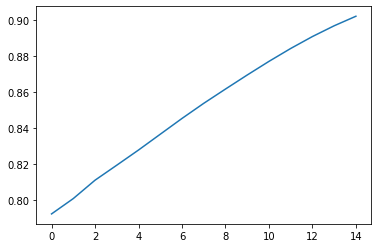

In [44]:
plot_graphs(history, 'accuracy')

KeyError: ignored

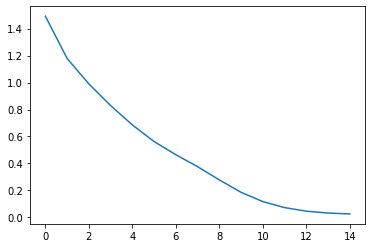

In [43]:
plot_graphs(history, 'loss')

In [45]:
query = "한국기술교육대학교 고용 및 직업능력개발 연구인력 박사후연구원 채용"

test_index_inputs, _ = enc_processing([query], word2idx)
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(" ".join([ idx2word[str(t)] for t in predict_tokens]))


NameError: ignored